In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

STANDARD_DEVIATION = 0.0005

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train, standard_deviation=STANDARD_DEVIATION, increment_percentage=2)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
436/436 [==============================] - 45s 73ms/step - loss: 2.1412 - val_loss: 1.7778
Epoch 2/100
436/436 [==============================] - 31s 72ms/step - loss: 1.6135 - val_loss: 1.5143
Epoch 3/100
436/436 [==============================] - 33s 75ms/step - loss: 1.4909 - val_loss: 1.5139
Epoch 4/100
436/436 [==============================] - 34s 77ms/step - loss: 1.4476 - val_loss: 1.4563
Epoch 5/100
436/436 [==============================] - 37s 84ms/step - loss: 1.3899 - val_loss: 1.3471
Epoch 6/100
436/436 [==============================] - 32s 73ms/step - loss: 1.3317 - val_loss: 1.4726
Epoch 7/100
436/436 [==============================] - 29s 67ms/step - loss: 1.3047 - val_loss: 1.2739
Epoch 8/100
436/436 [==============================] - 31s 72ms/step - loss: 1.2607 - val_loss: 1.2436
Epoch 9/100
436/436 [==============================] - 31s 70ms/step - loss: 1.2338 - val_loss: 1.2880
Epoch 10/100
436/436 [==============================] - 32s 74ms/step - l

436/436 [==============================] - 29s 67ms/step - loss: 0.6014 - val_loss: 0.8445
Epoch 80/100
436/436 [==============================] - 29s 67ms/step - loss: 0.6232 - val_loss: 0.7781
Epoch 81/100
436/436 [==============================] - 29s 66ms/step - loss: 0.5964 - val_loss: 0.7903
Epoch 82/100
436/436 [==============================] - 29s 66ms/step - loss: 0.6065 - val_loss: 0.7612T 
Epoch 83/100
436/436 [==============================] - 29s 66ms/step - loss: 0.5957 - val_loss: 0.7683TA:  - ETA: 0s - loss:
Epoch 84/100
436/436 [==============================] - 29s 66ms/step - loss: 0.5889 - val_loss: 0.7585
Epoch 85/100
436/436 [==============================] - 29s 66ms/step - loss: 0.5817 - val_loss: 0.7729
Epoch 86/100
436/436 [==============================] - 29s 66ms/step - loss: 0.5855 - val_loss: 0.7746 ETA: 1s - loss - ETA: 1
Epoch 87/100
436/436 [==============================] - 29s 66ms/step - loss: 0.5859 - val_loss: 0.7587s - loss: 
Epoch 88/100
436/43

# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 1s 27ms/step - loss: 2.7106
2.7106456756591797


## Loss

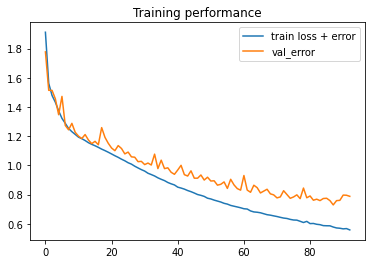

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

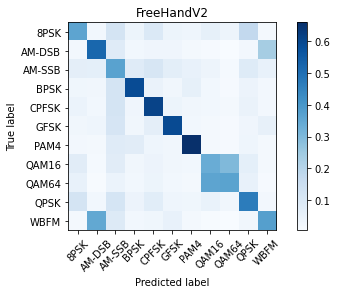

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09101040118870728
Overall Accuracy:  0.09759704251386321
Overall Accuracy:  0.10745846588900672
Overall Accuracy:  0.11243851018973998
Overall Accuracy:  0.13619942196531792
Overall Accuracy:  0.18546365914786966
Overall Accuracy:  0.2629881762809029
Overall Accuracy:  0.3710029069767442
Overall Accuracy:  0.4639687610933617
Overall Accuracy:  0.5790797987059669
Overall Accuracy:  0.6499636891793754
Overall Accuracy:  0.7021276595744681
Overall Accuracy:  0.7301707779886148
Overall Accuracy:  0.7231343283582089
Overall Accuracy:  0.736671469740634
Overall Accuracy:  0.7349617207437112
Overall Accuracy:  0.7178822658274713
Overall Accuracy:  0.7183151560737119
Overall Accuracy:  0.7310243183492999
Overall Accuracy:  0.7207885304659498


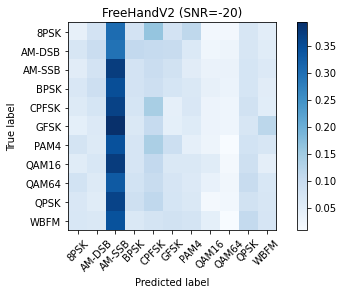

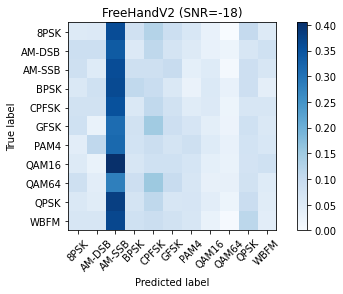

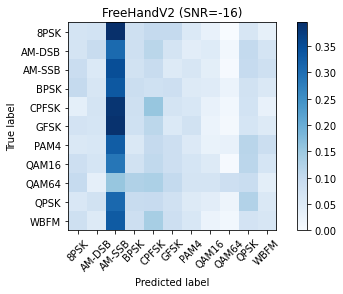

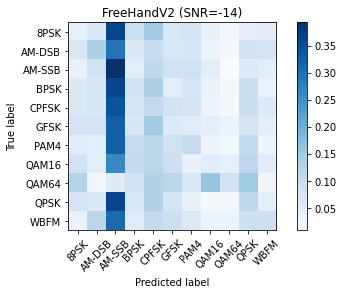

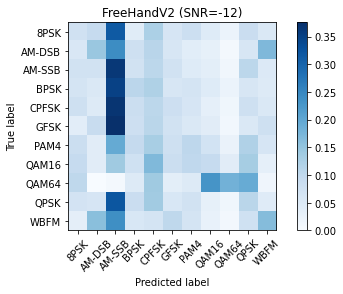

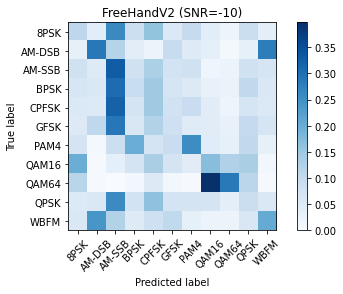

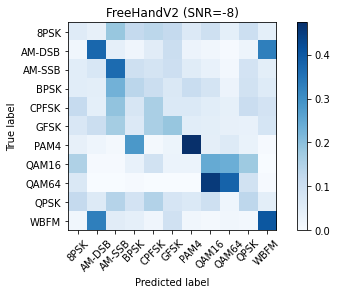

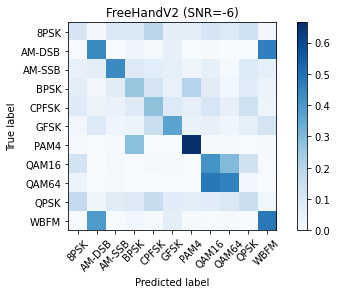

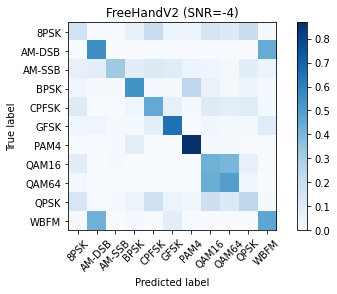

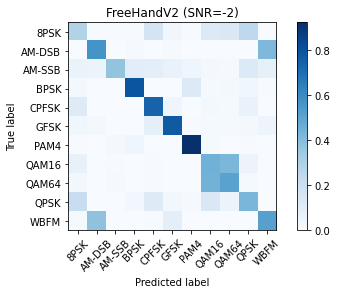

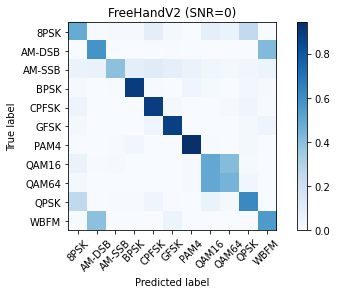

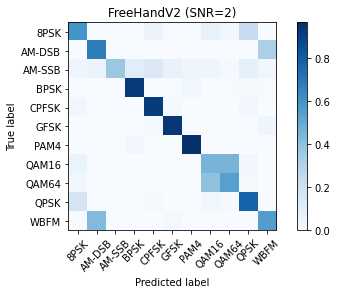

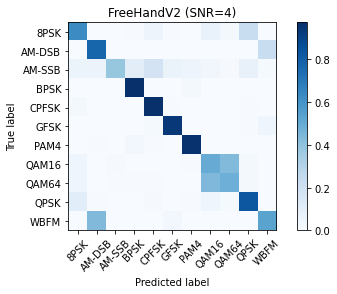

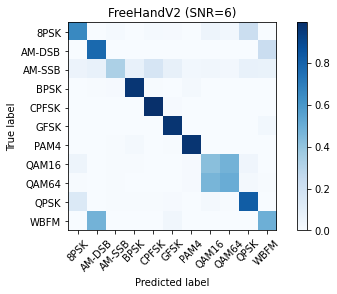

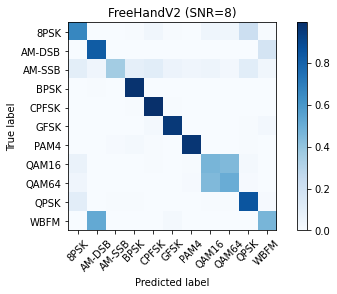

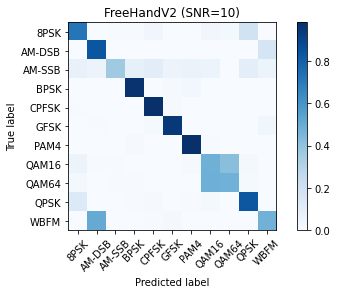

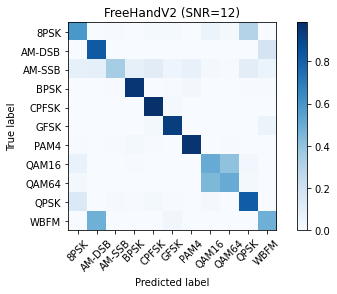

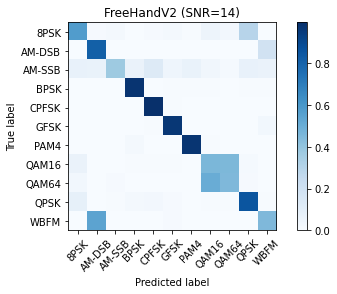

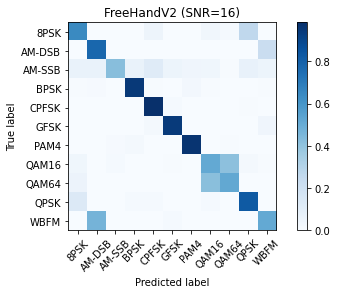

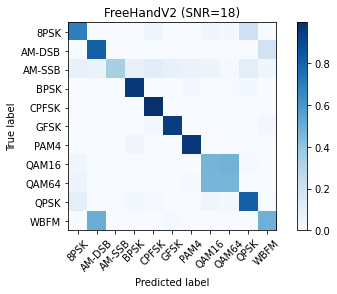

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,10,11,13,18,26,37,46,57,64,70,73,72,73,73,71,71,73,72


In [18]:
import statistics

statistics.mean(acc.values())

0.4786123530126463

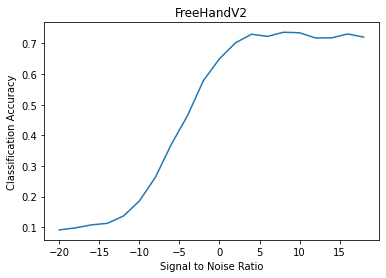

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)